# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [6]:
env.action_space.n

2

In [7]:
print("max state values: ", env.observation_space.high)
print("min state values: ", env.observation_space.low)
#cart position, velocity and pole angle, angular velocity.

max state values:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
min state values:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [8]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01273971 -0.00449024  0.04235275 -0.01184172]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [9]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01264991 -0.2001932   0.04211592  0.29389745]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [10]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    #print(reward)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
#performs around 10 steps before failing.

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

## **Q Learning Agent**

First, we initiliased the Q table with a fixed number of bins (where number of bins = 20) for each observation space dimension. This was done to discretise the continuous state space into discrete states. 

The Q table is initialised with random values within a fixed range such that the algorithm can explore different actions in each state.

In [11]:
def create_bins_and_q_table():

	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]

	qTable = np.random.uniform(low=-2, high=0, size=([numBins] * obsSpaceSize + [env.action_space.n]))

	return bins, obsSpaceSize, qTable

Next, we created a function to turn continuous state space into discrete states.

The function would iterate over each dimension of state and np.digitalize function will find the inddex in which thee state value falls. -1 will turn bin into the corresponding index in the Q table.

In [12]:
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)


We used Q learning to train our agent. 
The Q learning runs 20, 000 episodes, with the learning rate of 0.1 and discount factor of 0.95. 
High number of epidoses of 20, 000 is choosen for better performance of the Q learning agent.

In [20]:
bins, obsSpaceSize, q_table = create_bins_and_q_table()
alpha = 0.1 #learning rate
gamma = 0.95 #discount between 0 and 1
num_episodes = 20000
ep_results = []
ep_reward = 0
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

We define the probability of selecting a random action (exploration) instead of highest Q-value (exploitation) using epsilon decaying.

We start with exploration setting (epsilon) = 1 and this value is going to be decayed as more episodes get to run.





In [21]:
# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = num_episodes // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

At the start of each episodes, 'done' is set to False to indicate the episode is not over, and the reward for the episode is initialisd to 0. 's', which indicate the current state ,is discritized.



We printed every 100 episodes, with its avaerage reward, minimum reward and maximum reward.
At the end of the iteration, the number of episodes were printed to ensure all 20, 000 episodes has been run and the overall average reward of 20, 000 episodes were calculated.

For every epidose, if the random number is greater than epsilon value, the agent select action with highest Q value from the Q table (exploitation); else the agent will select a random action and explore the environment.

The agent will then call env.step(action) to get new state, reward and done, which the new state will then get discretised. The reward is then added to the total rewards for that episode. 

For the cases which the episode ends and the total episode reward is less than 200, the reward is set to -375. This serves as penalty for not completing task such that agent will tend to complete the task as quickly as possible by minimising the steps it take to complete the episode and receive a higher reward. (discourage agent from exploring the environment too much without completing the task, which this action leads to reward less than 200)

The maximum Q value will be calculated and updated if there is any change. The current Q value is retrived from the Q table, and the new Q value is calculated with the Q learning formula:
final_QValue = (1-alpha)current_QValue + alpha(reward + gamma*maxFuture_QValue) 

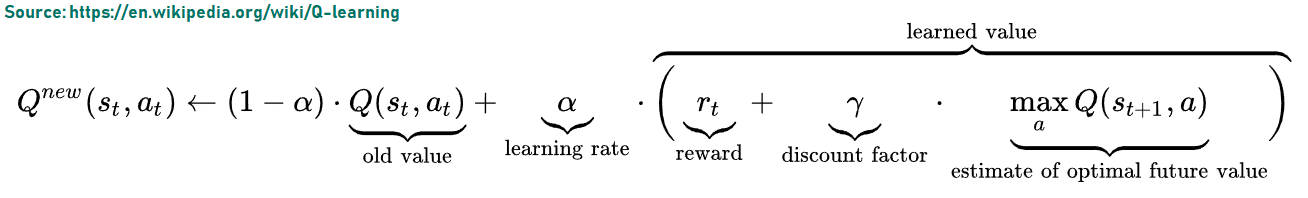

The current state is updated to the new state using s = newDiscreteState, until the episode is complete

After each episode, the total episode reward is appended to the ep_results list, and the epsilon value is updated using an epsilon decay schedule. If the current episode is between START_EPSILON_DECAYING and END_EPSILON_DECAYING, the epsilon value is decreased using an exponential decay function. 

We printed the the average, minimum, and maximum total episode reward for the every 100 episodes.

Lastly, we also printed the length of episodes (number of episodes) to ensure that all 20000 episodes were run.
The overall average of 20000 episodes were also printed

In [22]:
for i in range(num_episodes):

  done = False
  s = get_discrete_state(env.reset(), bins, obsSpaceSize)
  ep_reward = 0

  while not done:
    if np.random.random() > epsilon:
      action = np.argmax(q_table[s])
    else:
      action = np.random.randint(0, env.action_space.n)

    new_state, reward, done, _ = env.step(action)
    newDiscreteState = get_discrete_state(new_state, bins, obsSpaceSize)
    #print(newDiscreteState)
    ep_reward += reward
    maxFuture_QValue = np.max(q_table[newDiscreteState])
    current_QValue = q_table[s + (action, )]
    
    if done and ep_reward < 200:
      reward = -375      

    final_QValue = (1-alpha)*current_QValue + alpha*(reward + gamma*maxFuture_QValue)
      #updating the q value (action) based on the reward and new state
    q_table[s + (action, )] = final_QValue
    s = newDiscreteState
  
  ep_results.append(ep_reward)

  if END_EPSILON_DECAYING >= i >= START_EPSILON_DECAYING:
    epsilon -= epsilon_decay_value

  if i % 100 == 0:
    latestRuns = ep_results[-100:]
    averageCnt = sum(latestRuns) / len(latestRuns)
    metrics['ep'].append(i)
    metrics['avg'].append(averageCnt)
    metrics['min'].append(min(latestRuns))
    metrics['max'].append(max(latestRuns))
    print("Run:", i, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))
    
print(len(ep_results))
sum(ep_results)/len(ep_results)

Run: 0 Average: 16.0 Min: 16.0 Max: 16.0
Run: 100 Average: 23.11 Min: 9.0 Max: 79.0
Run: 200 Average: 21.37 Min: 9.0 Max: 69.0
Run: 300 Average: 21.52 Min: 8.0 Max: 54.0
Run: 400 Average: 22.52 Min: 9.0 Max: 66.0
Run: 500 Average: 21.99 Min: 8.0 Max: 73.0
Run: 600 Average: 22.21 Min: 10.0 Max: 54.0
Run: 700 Average: 23.55 Min: 9.0 Max: 61.0
Run: 800 Average: 27.39 Min: 10.0 Max: 83.0
Run: 900 Average: 27.38 Min: 8.0 Max: 81.0
Run: 1000 Average: 27.44 Min: 10.0 Max: 70.0
Run: 1100 Average: 25.95 Min: 9.0 Max: 94.0
Run: 1200 Average: 25.24 Min: 9.0 Max: 70.0
Run: 1300 Average: 29.95 Min: 10.0 Max: 84.0
Run: 1400 Average: 29.37 Min: 11.0 Max: 107.0
Run: 1500 Average: 34.86 Min: 11.0 Max: 105.0
Run: 1600 Average: 26.01 Min: 8.0 Max: 77.0
Run: 1700 Average: 26.38 Min: 10.0 Max: 103.0
Run: 1800 Average: 34.73 Min: 10.0 Max: 101.0
Run: 1900 Average: 30.34 Min: 9.0 Max: 104.0
Run: 2000 Average: 35.65 Min: 9.0 Max: 101.0
Run: 2100 Average: 35.59 Min: 10.0 Max: 147.0
Run: 2200 Average: 43.98 Min

180.84835

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

##Performance of Our Q Learning Agent 

for task 2, as our agent is already developed in task 1 and only 100 episodes would be run, we chose epsilon value of 0.1 such that our agent will choose the best action based on the Q-table 90% of the time and explore random actions 10% of the time. 

By choosing the epsilon value of 0.1, the agent can continue to explore new actions and potentially find better strategies while also relying on its learned knowledge.

In [34]:
rewards = []
epsilon = 0.1
for i in range(100):
    state = env.reset()
    done = False
    episode_reward = 0
    
    while not done:
  
        state = get_discrete_state(state, bins, obsSpaceSize)
        #choose the best action from the q_table 
        action = np.argmax(q_table[state])

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update the cumulative reward and the state
        episode_reward += reward
        state = next_state

    # Append the cumulative reward to the rewards list
    rewards.append(episode_reward)
avgRewardOver100episodes = sum(rewards)/len(rewards)
avgRewardOver100episodes

257.75

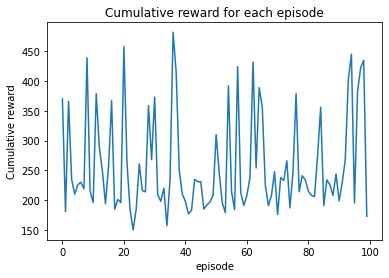

In [35]:
plt.plot(rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [36]:
eprewards = np.array(rewards)
print("Average cumulative reward:", eprewards.mean())
print("Is my agent good enough?", eprewards.mean() > 195)

Average cumulative reward: 257.75
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [37]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import pygame
from pygame import gfxdraw

In [39]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
cumulative_reward = 0
observation = env.reset()
while True:
    env.render()
    #our agent:
    observation = get_discrete_state(observation, bins, obsSpaceSize)
    #choose the best action from the q_table 
    action = np.argmax(q_table[observation])
    observation, reward, done, info = env.step(action) 
    cumulative_reward += reward
    if done: 
      break;    
print("Cumulative Reward: ", cumulative_reward)
env.close()
show_video()

Cumulative Reward:  295.0


Plug your agent to the code below to obtain rendered result.